In [1]:
import os
import gc
import traceback
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
pd.set_option('display.max_columns', None)
! pip install datatable
!ls
def  set_of_google_colab(str_path):   #str_path是改变当前的.ipynb的路径
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(str_path) 

    !ls
set_of_google_colab('/content/drive/MyDrive/G-search/src')
import gresearch_crypto

drive  sample_data
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
baseline_1.ipynb  model_weight.data-00000-of-00001
checkpoint	  model_weight.index
gresearch_crypto  my_model
model.pkl	  time-series-modeling-lstm.ipynb
model.png	  wandb


In [2]:
DEVICE = "TPU" #or "GPU"
SEED = 42
EPOCHS = 10
DEBUG = True
N_ASSETS = 14
WINDOW_SIZE = 15
BATCH_SIZE = 1024
PCT_VALIDATION = 10 # last 10% of the data are used as validation set

In [3]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except: print("failed to initialize TPU")
    else: DEVICE = "GPU"
if DEVICE != "TPU": strategy = tf.distribute.get_strategy()
if DEVICE == "GPU": print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

connecting to TPU...
Num GPUs Available:  1


In [4]:
import datatable as dt
#extra_data_files = {0: '../input/cryptocurrency-extra-data-binance-coin', 2: '../input/cryptocurrency-extra-data-bitcoin-cash', 1: '../input/cryptocurrency-extra-data-bitcoin', 3: '../input/cryptocurrency-extra-data-cardano', 4: '../input/cryptocurrency-extra-data-dogecoin', 5: '../input/cryptocurrency-extra-data-eos-io', 6: '../input/cryptocurrency-extra-data-ethereum', 7: '../input/cryptocurrency-extra-data-ethereum-classic', 8: '../input/cryptocurrency-extra-data-iota', 9: '../input/cryptocurrency-extra-data-litecoin', 11: '../input/cryptocurrency-extra-data-monero', 10: '../input/cryptocurrency-extra-data-maker', 12: '../input/cryptocurrency-extra-data-stellar', 13: '../input/cryptocurrency-extra-data-tron'}
data_path = '../input/g-research-crypto-forecasting/'
# Uncomment to load the original csv [slower]
orig_df_train = pd.read_csv(data_path + 'train.csv') 
supp_df_train = pd.read_csv(data_path + 'supplemental_train.csv')
df_asset_details = pd.read_csv(data_path  + 'asset_details.csv')
assets_details=df_asset_details = pd.read_csv(data_path  + 'asset_details.csv')
# orig_df_train = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_train.jay').to_pandas()
# df_asset_details = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
# supp_df_train = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_supplemental_train.jay').to_pandas()
# assets_details = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
asset_weight_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Weight'].tolist()[idx] for idx in range(len(assets_details))}
asset_name_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Asset_Name'].tolist()[idx] for idx in range(len(assets_details))}

# def load_training_data_for_asset(asset_id, load_jay = True):
#     dfs = []
#     if INCCOMP: dfs.append(orig_df_train[orig_df_train["Asset_ID"] == asset_id].copy())
#     if INCSUPP: dfs.append(supp_df_train[supp_df_train["Asset_ID"] == asset_id].copy())
    
#     if load_jay:
#         if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.jay').to_pandas())
#         if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.jay').to_pandas())
#         if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.jay').to_pandas())
#         if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.jay').to_pandas())
#         if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.jay').to_pandas())
#     else: 
#         if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'))
#         if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'))
#         if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'))
#         if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'))
#         if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'))
#     df = pd.concat(dfs, axis = 0) if len(dfs) > 1 else dfs[0]
#     df['date'] = pd.to_datetime(df['timestamp'], unit = 's')
#     if LOAD_STRICT: df = df.loc[df['date'] < "2021-06-13 00:00:00"]    
#     df = df.sort_values('date')
#     return df

# def load_data_for_all_assets():
#     dfs = []
#     for asset_id in list(extra_data_files.keys()): dfs.append(load_training_data_for_asset(asset_id))
#     return pd.concat(dfs)

In [5]:
# LOAD STRICT? YES=1 NO=0 | see: https://www.kaggle.com/julian3833/proposal-for-a-meaningful-lb-strict-lgbm
# LOAD_STRICT = True

# # WHICH YEARS TO INCLUDE? YES=1 NO=0
# INC2021 = 0
# INC2020 = 0
# INC2019 = 0
# INC2018 = 0
# INC2017 = 0
# INCCOMP = 1
# INCSUPP = 0
orig_df_train['date'] = pd.to_datetime(orig_df_train['timestamp'], unit = 's')
# #     if LOAD_STRICT: df = df.loc[df['date'] < "2021-06-13 00:00:00"]    
orig_df_train = orig_df_train.sort_values('date')
train = orig_df_train.sort_values('timestamp').set_index("timestamp")
if DEBUG: train = train[10000000:]

test = pd.read_csv(data_path + 'example_test.csv')
sample_prediction_df = pd.read_csv(data_path + 'example_sample_submission.csv')
assets = pd.read_csv(data_path + 'asset_details.csv')
assets_order = pd.read_csv(data_path + 'supplemental_train.csv').Asset_ID[:N_ASSETS]
assets_order = dict((t,i) for i,t in enumerate(assets_order))




In [6]:
#pd.read_csv(data_path + 'supplemental_train.csv').Asset_ID[:N_ASSETS]

In [7]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


In [8]:
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']
def get_features(df, row = False):
    df_feat = df
    df_feat['spread'] = df_feat['High'] - df_feat['Low']
    df_feat['mean_trade'] = df_feat['Volume']/df_feat['Count']
    df_feat['log_price_change'] = np.log(df_feat['Close']/df_feat['Open'])
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat['trade'] = df_feat['Close'] - df_feat['Open']
    df_feat['gtrade'] = df_feat['trade'] / df_feat['Count']
    df_feat['shadow1'] = df_feat['trade'] / df_feat['Volume']
    df_feat['shadow3'] = df_feat['upper_Shadow'] / df_feat['Volume']
    df_feat['shadow5'] = df_feat['lower_Shadow'] / df_feat['Volume']
    df_feat['diff1'] = df_feat['Volume'] - df_feat['Count']
    df_feat['mean1'] = (df_feat['shadow5'] + df_feat['shadow3']) / 2
    df_feat['mean2'] = (df_feat['shadow1'] + df_feat['Volume']) / 2
    df_feat['mean3'] = (df_feat['trade'] + df_feat['gtrade']) / 2
    df_feat['mean4'] = (df_feat['diff1'] + df_feat['upper_Shadow']) / 2
    df_feat['mean5'] = (df_feat['diff1'] + df_feat['lower_Shadow']) / 2
    df_feat['UPS'] = (df_feat['High'] - np.maximum(df_feat['Close'], df_feat['Open']))
    df_feat['UPS'] = df_feat['UPS']
    df_feat['LOS'] = (np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low'])
    df_feat['LOS'] = df_feat['LOS']
    df_feat['RNG'] = ((df_feat['High'] - df_feat['Low']) / df_feat['VWAP'])
    df_feat['RNG'] = df_feat['RNG']
    df_feat['MOV'] = ((df_feat['Close'] - df_feat['Open']) / df_feat['VWAP'])
    df_feat['MOV'] = df_feat['MOV']
    df_feat['CLS'] = ((df_feat['Close'] - df_feat['VWAP']) / df_feat['VWAP'])
    df_feat['CLS'] = df_feat['CLS']
    df_feat['LOGVOL'] = np.log(1. + df_feat['Volume'])
    df_feat['LOGVOL'] = df_feat['LOGVOL']
    df_feat['LOGCNT'] = np.log(1. + df_feat['Count'])
    df_feat['LOGCNT'] = df_feat['LOGCNT']
    df_feat["Close/Open"] = df_feat["Close"] / df_feat["Open"]
    df_feat["Close-Open"] = df_feat["Close"] - df_feat["Open"]
    df_feat["High-Low"] = df_feat["High"] - df_feat["Low"]
    df_feat["High/Low"] = df_feat["High"] / df_feat["Low"]
    if row: df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean()
    else: df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis = 1)
    df_feat["High/Mean"] = df_feat["High"] / df_feat["Mean"]
    df_feat["Low/Mean"] = df_feat["Low"] / df_feat["Mean"]
    df_feat["Volume/Count"] = df_feat["Volume"] / (df_feat["Count"] + 1)
    mean_price = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    median_price = df_feat[['Open', 'High', 'Low', 'Close']].median(axis=1)
    df_feat['high2mean'] = df_feat['High'] / mean_price
    df_feat['low2mean'] = df_feat['Low'] / mean_price
    df_feat['high2median'] = df_feat['High'] / median_price
    df_feat['low2median'] = df_feat['Low'] / median_price
    df_feat['volume2count'] = df_feat['Volume'] / (df_feat['Count'] + 1)
    return df_feat

train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']] = train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].astype(np.float32)
print(train.shape)
train['Target'] = train['Target'].fillna(0)
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)
df = train[['Asset_ID', 'Target']].copy()
times = dict((t,i) for i,t in enumerate(df.index.unique()))
df['id'] = df.index.map(times)
df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
ids = df.id.copy()
del df
train = get_features(train)
train = train[train.columns[0:15]]
train_features = [i for i in train.columns if i not in ['Target', 'date', 'timestamp', 'Asset_ID', 'groups']]
#train = reduce_mem_usage(train)


(14236806, 10)


In [9]:
train.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,date,spread,mean_trade,log_price_change,upper_Shadow,lower_Shadow
timestamp,,,,,,,,,,,,,,,
1567988760,0,26.0,22.347000,22.350000,22.322201,22.328800,728.830017,22.333281,-0.001786,2019-09-09 00:26:00,0.027800,28.031923,-0.000815,0.003000,0.006599
1567988760,1,339.0,10407.431641,10431.000000,10392.639648,10407.988281,18.114481,10408.004883,0.000031,2019-09-09 00:26:00,38.360352,0.053435,0.000054,23.011719,14.791992
1567988760,5,238.0,3.762150,3.774200,3.757000,3.762500,16743.089844,3.763894,-0.001891,2019-09-09 00:26:00,0.017200,70.349113,0.000093,0.011700,0.005150
1567988760,2,65.0,306.216675,306.720001,305.950012,306.500000,51.470516,306.385681,-0.001868,2019-09-09 00:26:00,0.769989,0.791854,0.000925,0.220001,0.266663
1567988760,3,66.0,0.046632,0.046700,0.046610,0.046642,189994.421875,0.046659,-0.003118,2019-09-09 00:26:00,0.000090,2878.703369,0.000225,0.000058,0.000021


In [10]:
# print(type(times))
# def dict_slice(adict, start, end):
#     keys = adict.keys()
#     dict_slice = {}
#     for k in list(keys)[start:end]:
#         dict_slice[k] = adict[k]
#     return dict_slice
# print(dict_slice(times,0,200))

In [11]:
train = train.sort_index()
ind = train.index.unique()

def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")   #填充空值，根据数据EDA发现最后一列和，target中含有空值
    return df
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
gc.collect()
train.shape
train.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,date,spread,mean_trade,log_price_change,upper_Shadow,lower_Shadow
timestamp,,,,,,,,,,,,,,,
1567988760,0,26.0,22.347000,22.350000,22.322201,22.328800,7.288300e+02,22.333281,-0.001786,2019-09-09 00:26:00,0.027800,28.031923,-0.000815,0.003000,0.006599
1567988760,6,166.0,180.712860,181.339996,180.410004,180.854279,2.935548e+02,180.780457,-0.000688,2019-09-09 00:26:00,0.929993,1.768402,0.000782,0.485718,0.302856
1567988760,7,27.0,6.604967,6.607200,6.601300,6.604367,1.004266e+03,6.604418,-0.000874,2019-09-09 00:26:00,0.005900,37.195038,-0.000091,0.002234,0.003067
1567988760,8,1.0,0.243900,0.243900,0.243900,0.243900,1.930000e+02,0.243900,-0.001638,2019-09-09 00:26:00,0.000000,193.000000,0.000000,0.000000,0.000000
1567988760,13,92.0,0.015746,0.015770,0.015730,0.015759,2.001856e+06,0.015749,-0.000116,2019-09-09 00:26:00,0.000040,21759.306641,0.000825,0.000011,0.000016


In [12]:
train = reduce_mem_usage(train)
# Matching records and marking generated rows as 'non-real'
train['group_num'] = train.index.map(times)   
train = train.dropna(subset=['group_num'])
train['group_num'] = train['group_num'].astype('int')
train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)
train.head(5)
train['is_real'] = train.id.isin(ids) * 1
train = train.drop('id', axis=1)
train.head()


Memory usage of dataframe is 1085.63 MB
Memory usage after optimization is: 714.23 MB
Decreased by 34.2%


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,date,spread,mean_trade,log_price_change,upper_Shadow,lower_Shadow,group_num,is_real
timestamp,,,,,,,,,,,,,,,,,
1567988760,0,26.0,22.343750,22.343750,22.328125,22.328125,7.288300e+02,22.328125,-0.001786,2019-09-09 00:26:00,0.027802,28.031923,-0.000815,0.003000,0.006599,0,1
1567988760,6,166.0,180.750000,181.375000,180.375000,180.875000,2.935548e+02,180.750000,-0.000688,2019-09-09 00:26:00,0.930176,1.768402,0.000782,0.485840,0.302734,0,1
1567988760,7,27.0,6.605469,6.605469,6.601562,6.605469,1.004266e+03,6.605469,-0.000874,2019-09-09 00:26:00,0.005901,37.195038,-0.000091,0.002234,0.003067,0,1
1567988760,8,1.0,0.243896,0.243896,0.243896,0.243896,1.930000e+02,0.243896,-0.001638,2019-09-09 00:26:00,0.000000,193.000000,0.000000,0.000000,0.000000,0,1
1567988760,13,92.0,0.015747,0.015778,0.015732,0.015762,2.001856e+06,0.015747,-0.000116,2019-09-09 00:26:00,0.000040,21759.306641,0.000825,0.000011,0.000016,0,1


In [13]:
# Features values for 'non-real' rows are set to zeros
features = train.columns.drop(['Asset_ID','group_num','is_real'])
train.loc[train.is_real == 0, features] = 0.
train['asset_order'] = train.Asset_ID.map(assets_order)
train = train.sort_values(by=['group_num', 'asset_order'])
train = reduce_mem_usage(train)

gc.collect()

Memory usage of dataframe is 1056.91 MB
Memory usage after optimization is: 828.39 MB
Decreased by 21.6%


0

In [14]:
targets = train['Target'].to_numpy().reshape(-1, N_ASSETS)
features = train.columns.drop(['Asset_ID', 'Target', 'group_num', 'is_real', 'date'])
col = train.columns
train = train[features]
display(train.head())
train = train.values
train = train.reshape(-1, N_ASSETS, train.shape[-1])
gc.collect()


,Count,Open,High,Low,Close,Volume,VWAP,spread,mean_trade,log_price_change,upper_Shadow,lower_Shadow,asset_order
timestamp,,,,,,,,,,,,,
1567988760,66.0,0.046631,0.046692,0.046600,0.046631,189994.421875,0.046661,0.000090,2878.703369,0.000225,0.000058,0.000022,0
1567988760,65.0,306.250000,306.750000,306.000000,306.500000,51.470516,306.500000,0.770020,0.791854,0.000925,0.219971,0.266602,1
1567988760,26.0,22.343750,22.343750,22.328125,22.328125,728.830017,22.328125,0.027802,28.031923,-0.000815,0.003000,0.006599,2
1567988760,339.0,10408.000000,10432.000000,10392.000000,10408.000000,18.114481,10408.000000,38.375000,0.053435,0.000054,23.015625,14.789062,3
1567988760,2.0,0.002464,0.002464,0.002464,0.002464,1212.380005,0.002464,0.000000,606.190002,0.000000,0.000000,0.000000,4


50

In [15]:
class sample_generator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, length):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.length = length
        self.size = len(x_set)
    def __len__(self): return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        batch_x=[]
        batch_y=[]
        for i in range(self.batch_size):
            start_ind = self.batch_size*idx + i
            end_ind = start_ind + self.length 
            if end_ind <= self.size:
                batch_x.append(self.x[start_ind : end_ind])
                batch_y.append(self.y[end_ind -1])
        return np.array(batch_x), np.array(batch_y)

In [16]:
X_train, X_test = train[:-len(train)//PCT_VALIDATION], train[-len(train)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train)//PCT_VALIDATION], targets[-len(train)//PCT_VALIDATION:]

In [17]:
train_generator = sample_generator(X_train, y_train, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
val_generator = sample_generator(X_test, y_test, length = WINDOW_SIZE, batch_size = BATCH_SIZE)

In [18]:
def MaxCorrelation(y_true,y_pred): return -tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))
def Correlation(y_true,y_pred): return tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))

def masked_mse(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_squared_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_mae(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_absolute_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_cosine(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.cosine_similarity(y_true_masked, y_pred_masked)

def get_squence_model(x):
    x = layers.LSTM(units=64, return_sequences=True)(x)
    return x

def get_model(n_assets = 14):
    x_input = keras.Input(shape=(train_generator[0][0].shape[1], n_assets, train_generator[0][0].shape[-1]))
    branch_outputs = []
    for i in range(n_assets):
        a = layers.Lambda(lambda x: x[:,:, i])(x_input) #选择第i个数据进行训练
        a = layers.Masking(mask_value = 0., )(a)
        a = get_squence_model(a)
        a = get_squence_model(a)
        a = get_squence_model(a)
        a = get_squence_model(a)
        #a = get_squence_model(a)
        a = layers.GlobalAvgPool1D()(a)
        branch_outputs.append(a)
    x = layers.Concatenate()(branch_outputs)
    x = layers.Dense(units = 128)(x)
    out = layers.Dense(units = n_assets)(x)
    model = keras.Model(inputs=x_input, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss = masked_cosine, metrics=[Correlation])
    return model
    
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 14, 13)  0           []                               
                                ]                                                                 
                                                                                                  
 lambda (Lambda)                (None, 15, 13)       0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 15, 13)       0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 15, 13)       0           ['input_1[0][0]']            

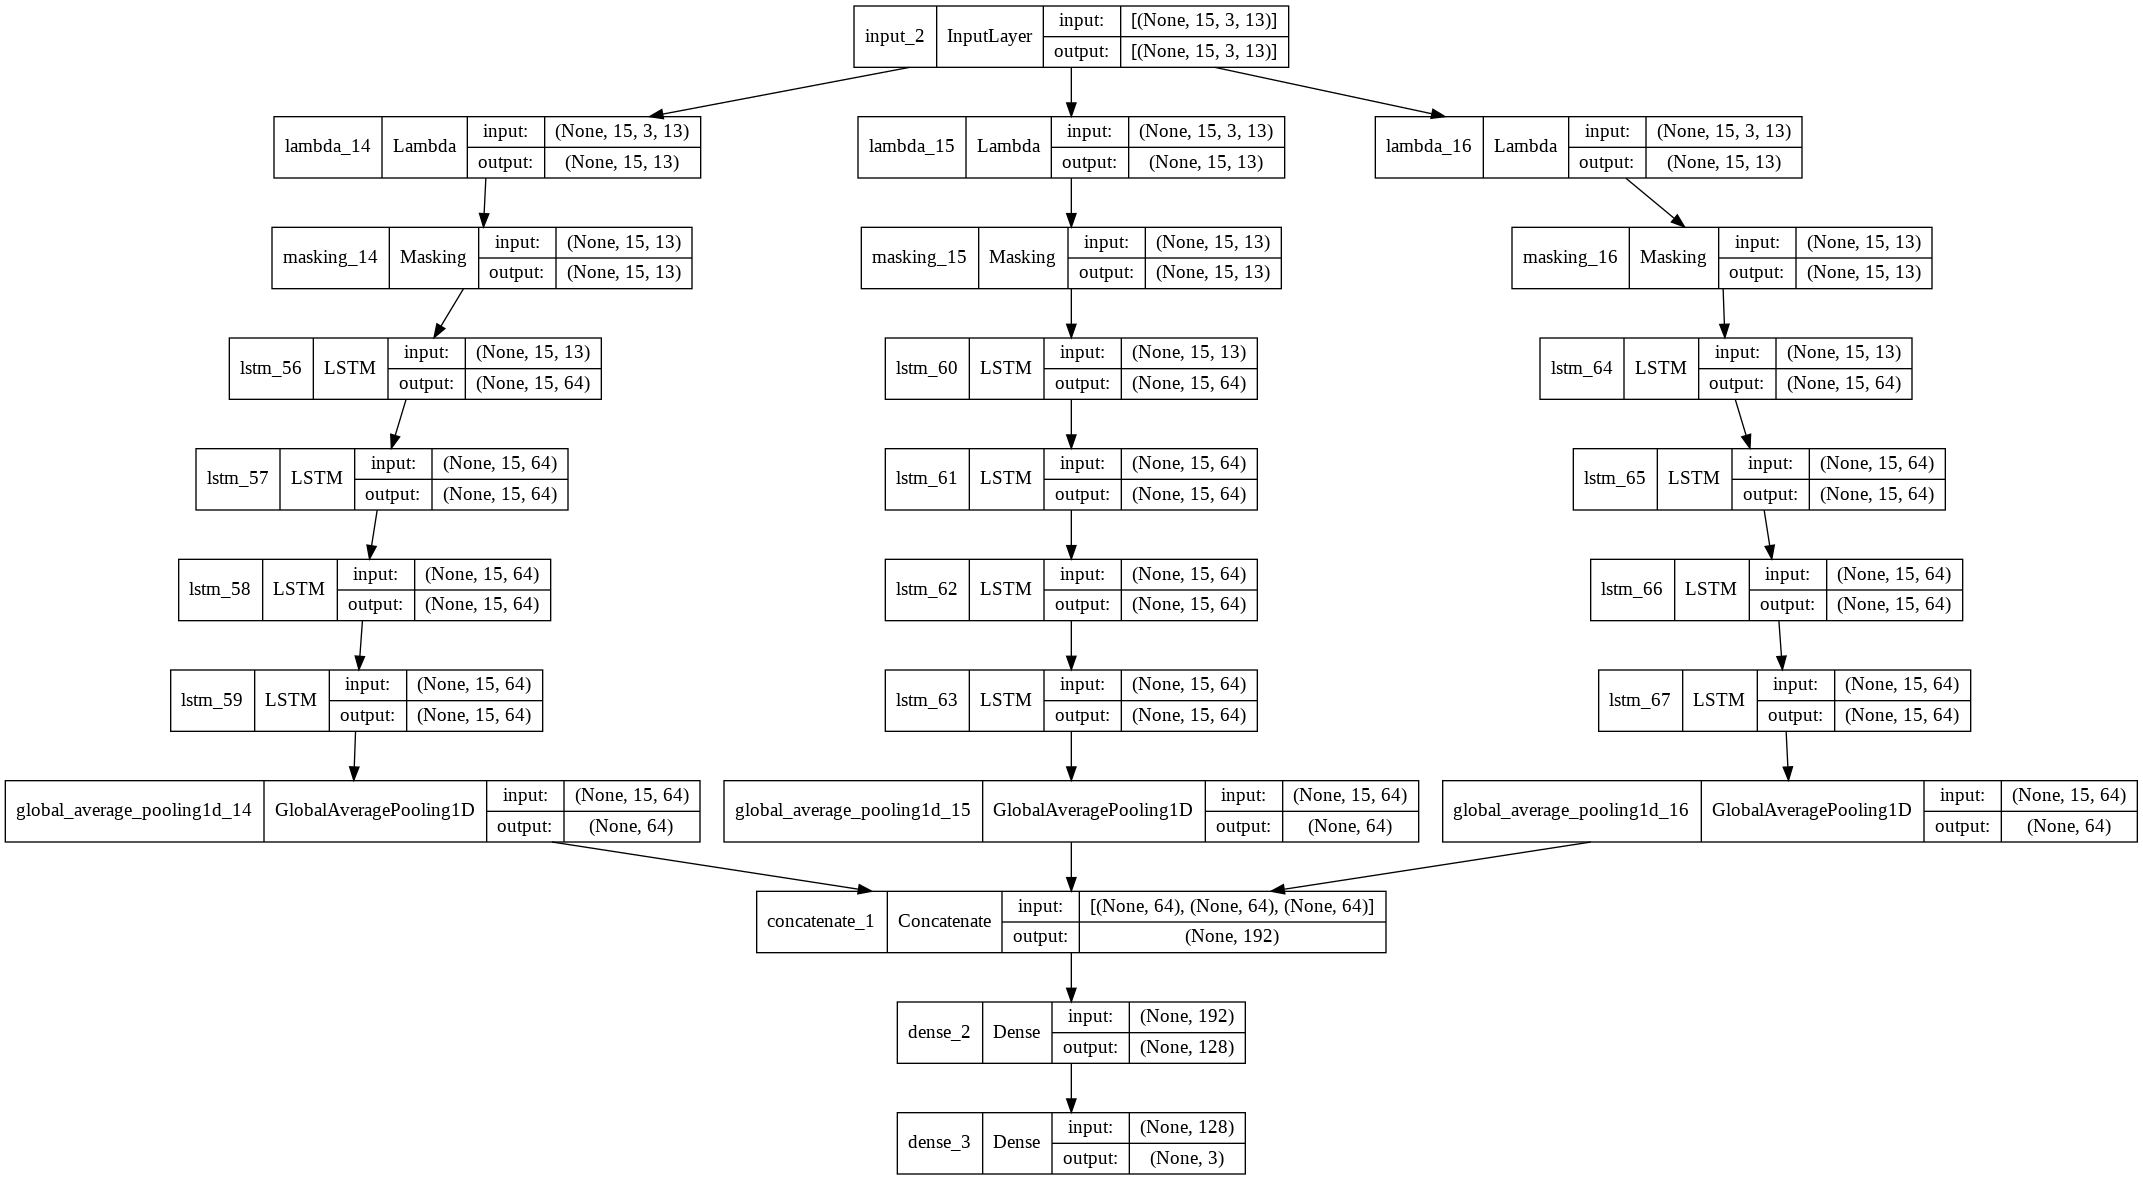

In [19]:
tf.keras.utils.plot_model(get_model(n_assets=3), show_shapes=True)

Index(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'spread',
       'mean_trade', 'log_price_change', 'upper_Shadow', 'lower_Shadow',
       'asset_order'],
      dtype='object')

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/10
941/941 [==============================] - 571s 364ms/step - loss: -0.0016 - Correlation: 0.0193 - val_loss: -0.0015 - val_Correlation: 0.0189 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009854132, shape=(), dtype=float32).
Epoch 2/10
941/941 [==============================] - 262s 279ms/step - loss: -0.0043 - Correlation: 0.0208 - val_loss: -0.0024 - val_Correlation: 0.0227 - lr: 9.8541e-04

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009710392, shape=(), dtype=float32).
Epoch 3/10
941/941 [==============================] - 262s 278ms/step - loss: -0.0047 - Correlation: 0.0214 - val_loss: -0.0034 - val_Correlat

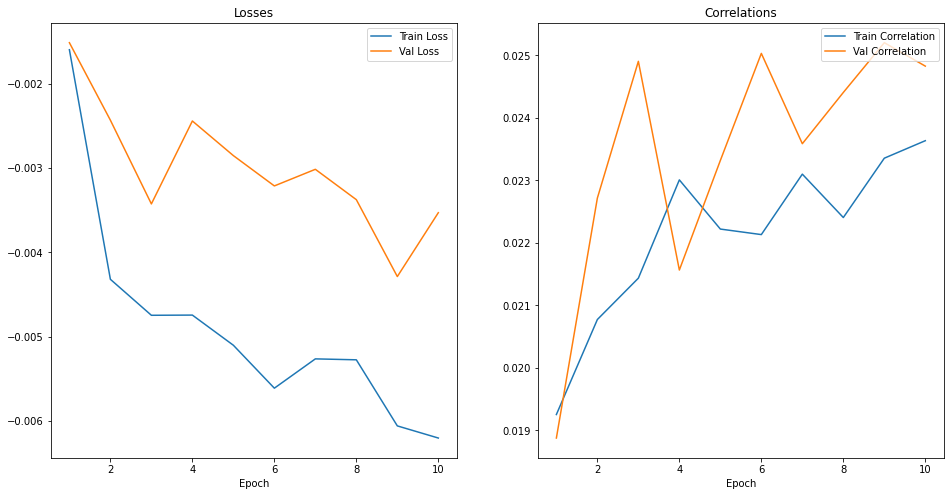

In [20]:
del train
gc.collect()

print(features)
tf.random.set_seed(0)
estop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 0, mode = 'min',restore_best_weights = True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5 * len(X_train) / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

# 读取权重到新模型
#model.load_weights('model_weight')
# history=model
history = model.fit(train_generator, validation_data = (val_generator), epochs = EPOCHS, callbacks = [lr, estop])
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
histories = pd.DataFrame(history.history)
epochs = list(range(1,len(histories)+1))
loss = histories['loss']
val_loss = histories['val_loss']
Correlation = histories['Correlation']
val_Correlation = histories['val_Correlation']
ax[0].plot(epochs, loss, label = 'Train Loss')
ax[0].plot(epochs, val_loss, label = 'Val Loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')
ax[1].plot(epochs, Correlation, label = 'Train Correlation')
ax[1].plot(epochs, val_Correlation, label = 'Val Correlation')
ax[1].set_title('Correlations')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')
fig.show()
gc.collect()
# The correlation coefficients by asset for the validation data
predictions = model.predict(val_generator)

print(f'Target shape: {predictions.shape}')





In [21]:
# model.summary()
# print(model.layers)

In [22]:
#在此处对train_generator变量进行研究，查看其不同维度的结果
#截取train_genorator中的收盘价格，绘制序列

#读取上述实验模型
# gc.collect()
# model.save_weights('model_weight')
# 创建新模型读取权重


# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("my_model")

# # Let's check:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )

# # The reconstructed model is already compiled and has retained the optimizer
# # state, so training can resume:
# reconstructed_model.fit(test_input, test_target)
#读取成功


# print(train_generator[0][0].shape)
# print(train_generator[0][0][0].shape)
# print(train_generator[0][0][0][0].shape)
# train_generator[0][0][0].head()

In [23]:
print(len(col))
print(X_test.shape)
print(X_test[:,:,:][:,5])
print(col)
i=0
i_close = list(col).index("Close")
i_close
X_test[:,i,:][:,i_close].shape

18
(106974, 14, 13)
[[1.8200000e+02 3.6621094e+00 3.6660156e+00 ... 3.5495758e-03
  1.4667511e-03 5.0000000e+00]
 [1.0700000e+02 3.6542969e+00 3.6562500e+00 ... 2.7599335e-03
  2.2602081e-03 5.0000000e+00]
 [8.7000000e+01 3.6523438e+00 3.6542969e+00 ... 2.7656555e-03
  4.0817261e-03 5.0000000e+00]
 ...
 [2.3600000e+02 4.1796875e+00 4.1835938e+00 ... 4.4670105e-03
  4.0321350e-03 5.0000000e+00]
 [6.3300000e+02 4.1796875e+00 4.2031250e+00 ... 4.2648315e-03
  4.0664673e-03 5.0000000e+00]
 [4.5000000e+02 4.2031250e+00 4.2031250e+00 ... 1.7604828e-03
  1.7404556e-03 5.0000000e+00]]
Index(['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Target', 'date', 'spread', 'mean_trade', 'log_price_change',
       'upper_Shadow', 'lower_Shadow', 'group_num', 'is_real', 'asset_order'],
      dtype='object')


(106974,)

['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target', 'date', 'spread', 'mean_trade', 'log_price_change', 'upper_Shadow', 'lower_Shadow', 'group_num', 'is_real', 'asset_order']
(106974,)
Cardano: 0.0175


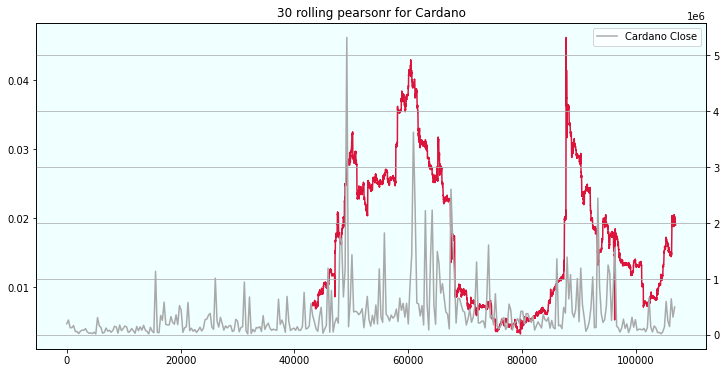

(106974,)
Bitcoin Cash: -0.0138


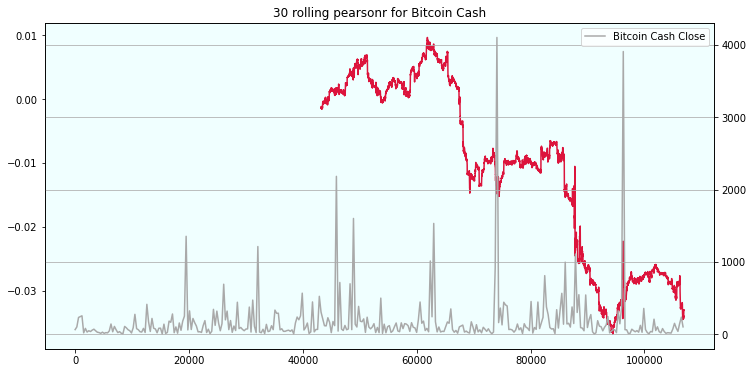

(106974,)
Binance Coin: 0.0089


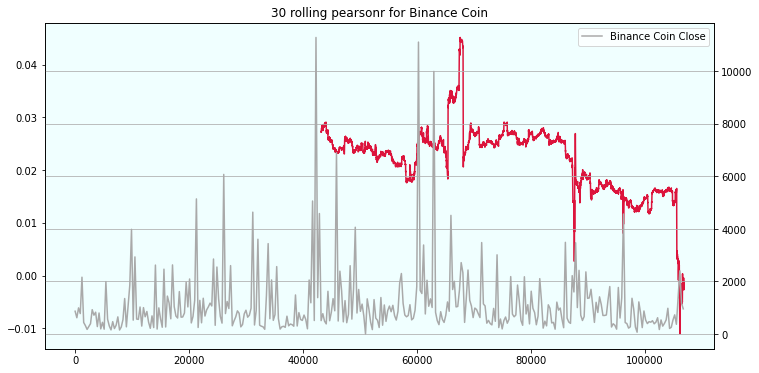

(106974,)
Bitcoin: -0.0150


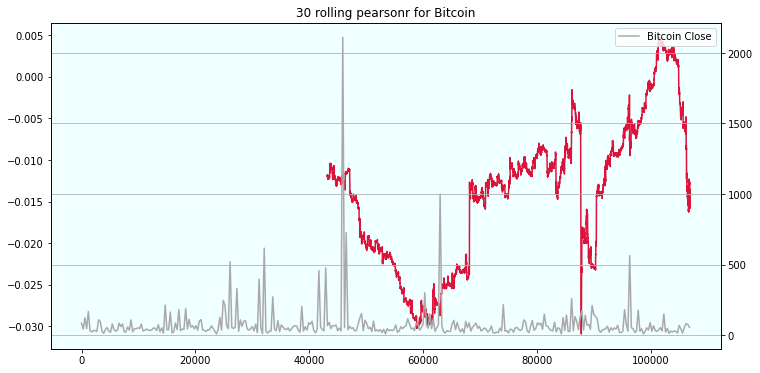

(106974,)
Dogecoin: 0.0003


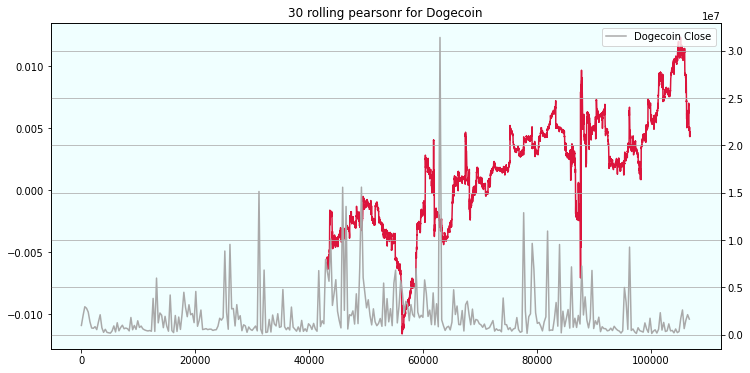

(106974,)
EOS.IO: 0.0030


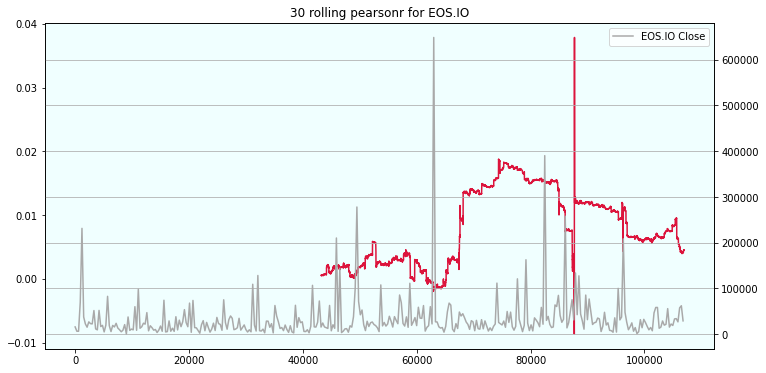

(106974,)
Ethereum Classic: -0.0105


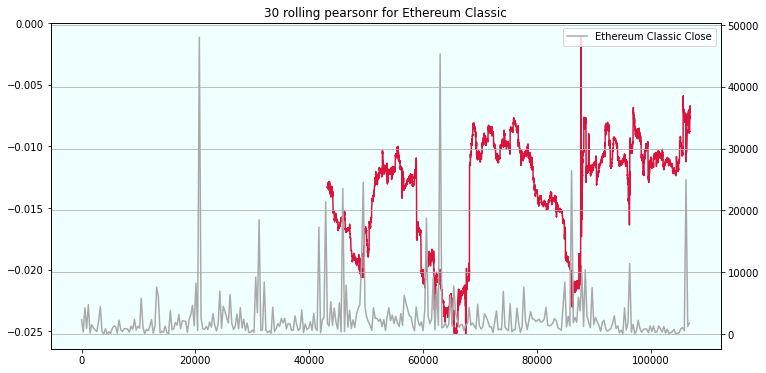

(106974,)
Ethereum: -0.0082


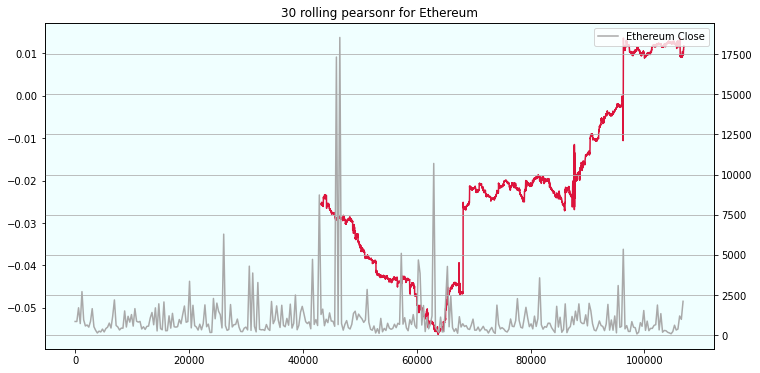

(106974,)
IOTA: 0.0090


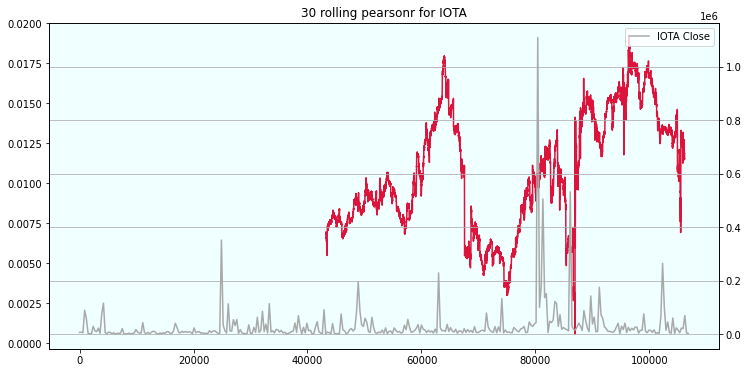

(106974,)
Litecoin: 0.0043


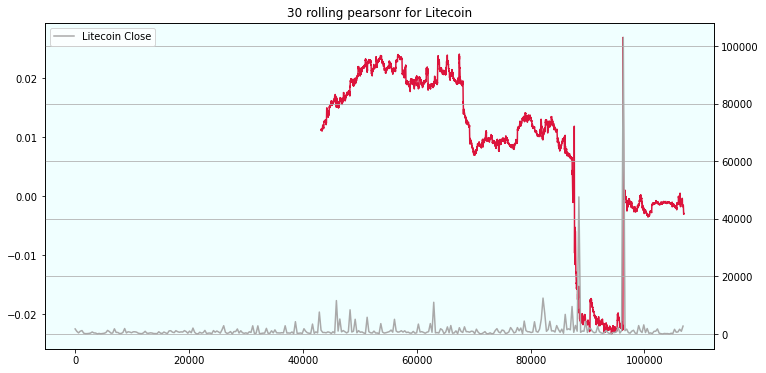

(106974,)
Maker: -0.0027


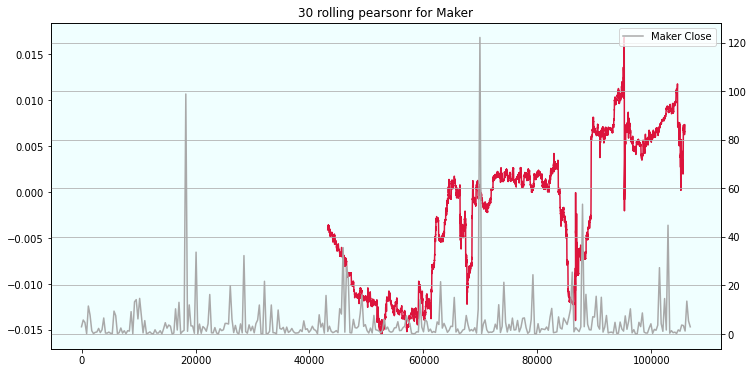

(106974,)
TRON: 0.0038


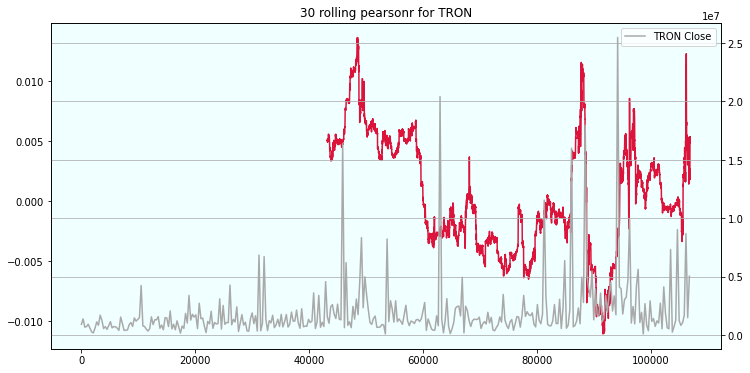

(106974,)
Stellar: 0.0037


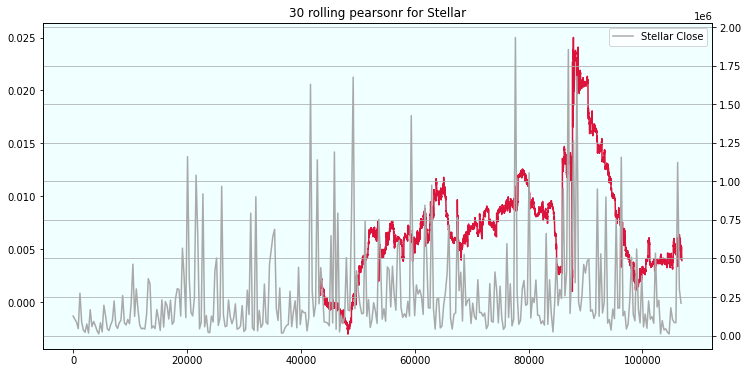

(106974,)
Monero: -0.0183


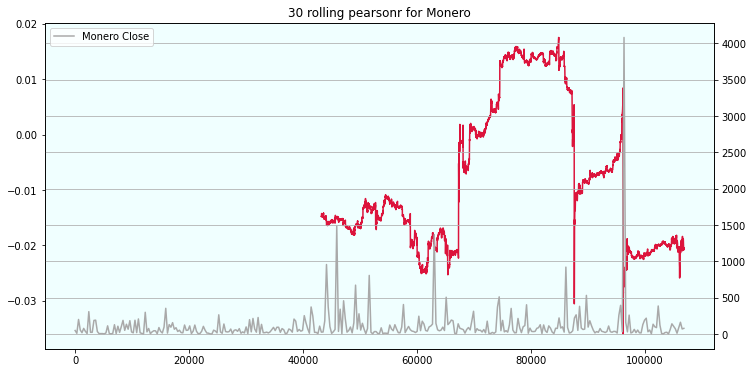

In [24]:
gc.collect()
def plot_result(df2,now_asset_name):    #自定义可视化结果函数
    try: plt.close()
    except: pass   
    fig = plt.figure(figsize = (12, 6))
    ax_left = fig.add_subplot(111)
    ax_left.set_facecolor('azure')    
    ax_right = ax_left.twinx()
    ax_left.plot(df2['y'].rolling(30*24*60).corr(df2['oof_preds'].rolling(30*24*60)),color = 'crimson', label = "Target WCorr")
    ax_right.plot(df2['Close'].iloc[::5*60], color = 'darkgrey', label = "%s Close" % now_asset_name)   
    plt.legend()
    plt.grid()
    plt.xlabel('Time')
    plt.title('30 rolling pearsonr for %s' % (now_asset_name))
    plt.show()
print(list(col))
i_close = list(col).index("Close")
for i in range(N_ASSETS):
    y_true = np.squeeze(y_test[WINDOW_SIZE - 1:, i])
    close_price = X_test[:,i,:][:,i_close]
    print(close_price.shape)
    y_pred = np.squeeze(predictions[:, i])
    real_target_ind = np.argwhere(y_true!=0)
    asset_id = list(assets_order.keys())[i]
    asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
    print(f"{asset_name}: {np.corrcoef(y_pred[real_target_ind].flatten(), y_true[real_target_ind].flatten())[0,1]:.4f}")
    re_dict ={'Close':pd.Series(close_price),'oof_preds':pd.Series( y_pred[real_target_ind].flatten() ),'y':pd.Series(y_true[real_target_ind].flatten())}
    result = pd.DataFrame(re_dict)
    #display(result.head())
    plot_result(result,asset_name)
    



In [25]:
#预测代码 参考gsearch的官方API detail introduction

sup = pd.read_csv('/content/drive/MyDrive/G-search/input/g-research-crypto-forecasting/supplemental_train.csv')[:WINDOW_SIZE * (N_ASSETS)]
placeholder = get_features(sup)
placeholder['asset_order'] = placeholder.Asset_ID.map(assets_order)
test_sample = np.array(placeholder[features])
test_sample = test_sample.reshape(-1, (N_ASSETS), test_sample.shape[-1])
test_sample = np.expand_dims(test_sample, axis=0)
example = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_test.jay').to_pandas()[:WINDOW_SIZE - 1]
example['asset_order'] = example.Asset_ID.map(assets_order) 
example = example[['Asset_ID','asset_order']]


env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    test_df = get_features(test_df)
    test_data = test_df.merge(example, how='outer', on='Asset_ID').sort_values('asset_order')    #连接测试集原始数据和新产生的特征
    test = np.array(test_data[features].fillna(0))
    test = test.reshape(-1, 1, N_ASSETS, test.shape[-1])
    test_sample = np.hstack([test_sample, test])[:,-1 * WINDOW_SIZE:]
    y_pred = model.predict(test_sample).squeeze().reshape(-1, 1).squeeze()      #预测数据
    test_data['Target'] = y_pred
    for _, row in test_df.iterrows():
        try: sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = test_data.loc[test_data['row_id'] == row['row_id'], 'Target'].item()
        except: sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = 0
    env.predict(sample_prediction_df)

ValueError: ignored